In [124]:
### basic libraries
import os
from json import dumps
import pandas as pd 

### carto libraries
import shapefile ### not necessary ?
import geopandas as gp
#from shapely.geometry import Polygon
from shapely.geometry import shape

### for plotting in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (10.0, 10.0)

from app.scripts.topojson import topojson

from pyproj import Proj, transform ### not necessary ?

crs_lambert93 = 2154
crs_WSG84     = 4326
inCRS  = 'epsg:%s' %(crs_lambert93)
outCRS = 'epsg:%s' %(crs_WSG84)
inProj  = Proj(init=inCRS)  # proj in  : Lambert 93
outProj = Proj(init=outCRS) # proj out : WSG 84

### TO DO : find topojson libraries to reduce output file size


In [125]:
### basic folders addresses and names
cwd = os.getcwd()

data_folder = "app/static/data"
carto_folder = "carto"

carto_path = os.path.join(cwd, data_folder, carto_folder)

print "-- cwd :"        , cwd
print "-- carto path : ", carto_path


-- cwd : /Users/jpy/Dropbox/_FLASK/concours_pesticides
-- carto path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto


In [126]:
### basic pandas tools

idx = pd.IndexSlice

def checkDTypes (df) :
    # check data type
    
    for index in df.index.names :
        print "---- index : ", index

    for col in df.columns :
        #label = col.values
        dtype = df[col].dtype
        
        print "---- dtypes col : ", col, "/", dtype
        

In [127]:
# cf : https://pypi.python.org/pypi/pyshp
# cf : http://gis.stackexchange.com/questions/183795/how-do-i-select-shapefiles-to-be-converted-to-geojson-in-folder-with-multiple-sh
# cf : https://github.com/mlaloux/Python-geo_interface-applications/blob/master/PyShp_geointerface.py

# cf : https://glenbambrick.com/tag/pyshp/
# cf : https://glenbambrick.com/2016/01/24/reproject-shapefile/

In [128]:
### SHP files 
_shp  = ".shp"
_json = ".json"
_copy = "_copy"

water_shp_fname = "PolygMasseDEauSouterraine"

## TO DO : add departements .shp for other datas than water (f.i. agriculture stats / src : Etalab)

In [129]:
### reading/writing - converting shp files to geojson
    
def geofile_path(filename, extension):
    path = os.path.join(carto_path , filename + extension )
    print "-- file path : ", path
    return path


In [130]:
### DEPRECATED : read .shp with shapefile
'''
def readSHP(filename):  
    # generator 
    reader = shapefile.Reader( root_carto_folder+ filename + _shp )  
    fields = reader.fields[1:]  
    field_names = [field[0] for field in fields]  
    for sr in reader.shapeRecords():  
        geom = sr.shape.__geo_interface__  
        atr = dict(zip(field_names, sr.record))  
        yield dict(geometry=geom,properties=atr)    
'''

def readSHP(filename) :
    
    # read the shapefile
    reader = shapefile.Reader( geofile_path( water_shp_fname, _shp ) )
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]

    buffer = []
    for sr in reader.shapeRecords():
       atr = dict(zip(field_names, sr.record))
       geom = sr.shape.__geo_interface__
       buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 

    # write the GeoJSON file (copy)
    geojson = open( os.path.join( carto_path, filename + _copy + _json), "w")
    geojson.write(dumps({"type": "FeatureCollection", "features": buffer}, indent=2) + "\n")
    geojson.close()
    

In [131]:
### options for gdf.read_file()
#import fiona; help(fiona.open)

### options for gdf.to_file()
#import fiona; fiona.supported_drivers

In [132]:
### read .shp with geopandas (greedy)

shp_encoding = "utf-8" ### doesnt work
shp_encoding = "latin-1" ### not sure

crs_source = crs_lambert93
#crs_source = "lcc" ### not sure
## {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84','no_defs': True}


# read file
#gdf = gp.read_file( geofile_path( water_shp_fname, _shp ), crs=crs_source, encoding=shp_encoding )
gdf = gp.GeoDataFrame.from_file( geofile_path( water_shp_fname, _shp ) )

# set and sort index
gdf.set_index(["CdBassinDC", "CdMasseDEa"], inplace=True)
gdf.sortlevel(inplace=True) 


-- file path :  /Users/jpy/Dropbox/_FLASK/concours_pesticides/app/static/data/carto/PolygMasseDEauSouterraine.shp


In [133]:
print gdf.shape

(1103, 24)


In [134]:
gdf.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1103 entries, (A, AG001) to (H, HG508)
Data columns (total 24 columns):
CdEcoregio    1103 non-null object
CdEuMasseD    1103 non-null object
CdPolygMas    1103 non-null object
Commentair    551 non-null object
DateCreati    1103 non-null object
DateMajMas    1103 non-null object
FrangeLitt    1103 non-null object
Karstique     1103 non-null object
LatMasseDE    1103 non-null float64
LonMasseDE    1103 non-null float64
MasseDEauA    1103 non-null object
MasseDEauT    1103 non-null object
NatureEcou    1103 non-null object
Niveau        1103 non-null int64
NomMasseDE    1103 non-null object
PrecSupMas    1103 non-null object
Regroupees    1103 non-null object
StMasseDEa    1103 non-null object
SurfaceAff    1103 non-null float64
SurfaceSsC    1103 non-null float64
SurfaceTot    1103 non-null float64
SystemeRef    1103 non-null object
TypeMasseD    1103 non-null object
geometry      1103 non-null object
dtypes: float64(5), int64(1

In [135]:
gdf.memory_usage().sum()

220043

In [136]:
gdf["area"] = gdf["geometry"].area

In [137]:
checkDTypes(gdf) 


---- index :  CdBassinDC
---- index :  CdMasseDEa
---- dtypes col :  CdEcoregio / object
---- dtypes col :  CdEuMasseD / object
---- dtypes col :  CdPolygMas / object
---- dtypes col :  Commentair / object
---- dtypes col :  DateCreati / object
---- dtypes col :  DateMajMas / object
---- dtypes col :  FrangeLitt / object
---- dtypes col :  Karstique / object
---- dtypes col :  LatMasseDE / float64
---- dtypes col :  LonMasseDE / float64
---- dtypes col :  MasseDEauA / object
---- dtypes col :  MasseDEauT / object
---- dtypes col :  NatureEcou / object
---- dtypes col :  Niveau / int64
---- dtypes col :  NomMasseDE / object
---- dtypes col :  PrecSupMas / object
---- dtypes col :  Regroupees / object
---- dtypes col :  StMasseDEa / object
---- dtypes col :  SurfaceAff / float64
---- dtypes col :  SurfaceSsC / float64
---- dtypes col :  SurfaceTot / float64
---- dtypes col :  SystemeRef / object
---- dtypes col :  TypeMasseD / object
---- dtypes col :  geometry / object
---- dtypes col :

In [115]:
test_geom = gdf.loc["A","AG001"]["geometry"]
print test_geom.area

CdBassinDC  CdMasseDEa
A           AG001         8.237526e+07
            AG001         8.681770e+08
dtype: float64


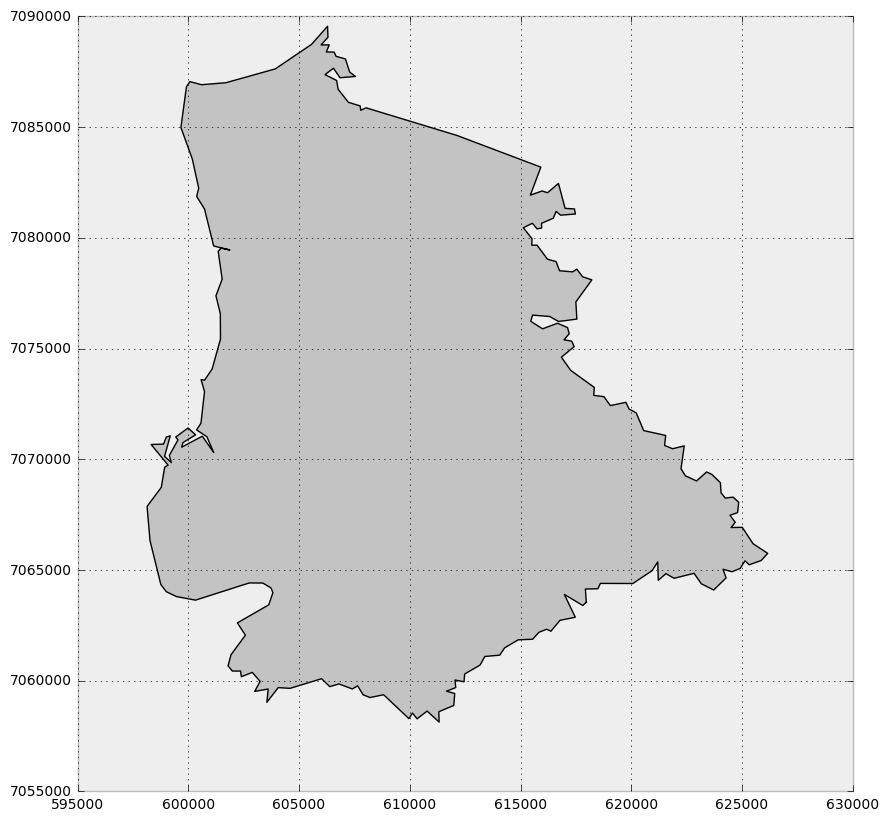

In [138]:
#gdf.head(10).plot()
#gdf.loc["A", "AG015"]["geometry"].simplify(200, preserve_topology=False).plot()
#gdf.loc["B1"]["geometry"].simplify(500, preserve_topology=False).plot()
#gdf.loc["A":"B1"]["geometry"].simplify(700, preserve_topology=False).plot()
gdf.loc["A","AG002"]["geometry"].simplify(100, preserve_topology=True).plot()

In [139]:
# check crs
gdf.crs

{u'ellps': u'GRS80',
 u'lat_0': 46.5,
 u'lat_1': 49,
 u'lat_2': 44,
 u'lon_0': 3,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'm',
 u'x_0': 700000,
 u'y_0': 6600000}

In [111]:
# change projection crs (greedy)
gdf.to_crs(epsg=crs_WSG84)


CdEcoregio CdEuMasseD CdPolygMas  \
CdBassinDC CdMasseDEa                                    
A          AG001              13    FRAG001   00000002   
           AG001              13    FRAG001   00000001   
           AG002              13    FRAG002   00000003   
           AG003              13    FRAG003   00000005   
           AG003              13    FRAG003   00000004   
           AG004              13    FRAG004   00000007   
           AG004              13    FRAG004   00000006   
           AG005              13    FRAG005   00000008   
           AG006              13    FRAG006   00000010   
           AG006              13    FRAG006   00000009   
           AG007              13    FRAG007   00000012   
           AG007              13    FRAG007   00000011   
           AG008              13    FRAG008   00000013   
           AG009              13    FRAG009   00000014   
           AG010              13    FRAG010   00000015   
           AG011              13    FRAG011   00000016   
           AG012              13    FRAG012   00000017   
           AG013              13    FRAG013   00000018   
           AG014              13    FRAG014   00000019   
           AG015              13    FRAG015   00000021   
           AG015              13    FRAG015   00000020   
           AG018              13    FRAG018   00000022   
B1         B1G007              8   FRB1G007   00000023   
           B1G009              8   FRB1G009   00000024   
           B1G009              8   FRB1G009   00000025   
           B1G009              8   FRB1G009   00000026   
           B1G011              8   FRB1G011   00000027   
           B1G011              8   FRB1G011   00000028   
           B1G011              8   FRB1G011   00000029   
           B1G013              8   FRB1G013   00000030   
...                          ...        ...        ...   
H          HG306              13    FRHG306   00001064   
           HG307              13    FRHG307   00001065   
           HG307              13    FRHG307   00001066   
           HG307              13    FRHG307   00001067   
           HG307              13    FRHG307   00001068   
           HG308              13    FRHG308   00001071   
           HG308              13    FRHG308   00001072   
           HG308              13    FRHG308   00001069   
           HG308              13    FRHG308   00001070   
           HG309              13    FRHG309   00001073   
           HG309              13    FRHG309   00001074   
           HG309              13    FRHG309   00001075   
           HG310              13    FRHG310   00001076   
           HG310              13    FRHG310   00001077   
           HG310              13    FRHG310   00001078   
           HG310              13    FRHG310   00001079   
           HG310              13    FRHG310   00001080   
           HG401               8    FRHG401   00001081   
           HG402              13    FRHG402   00001082   
           HG402              13    FRHG402   00001083   
           HG501               8    FRHG501   00001084   
           HG502              13    FRHG502   00001085   
           HG503              13    FRHG503   00001086   
           HG503              13    FRHG503   00001087   
           HG504              13    FRHG504   00001088   
           HG505              13    FRHG505   00001089   
           HG506              13    FRHG506   00001090   
           HG507              13    FRHG507   00001091   
           HG507              13    FRHG507   00001092   
           HG508              13    FRHG508   00001093   

                                                              Commentair  \
CdBassinDC CdMasseDEa                                                      
A          AG001                                                    None   
           AG001                                                    None   
           AG002                                               

In [112]:
gdf.crs

{u'ellps': u'GRS80',
 u'lat_0': 46.5,
 u'lat_1': 49,
 u'lat_2': 44,
 u'lon_0': 3,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'm',
 u'x_0': 700000,
 u'y_0': 6600000}

In [113]:
gdf.head(50).loc[ idx[:,"AG015"], idx["MasseDEauA":]]


MasseDEauA MasseDEauT NatureEcou  Niveau  \
CdBassinDC CdMasseDEa                                            
A          AG015               Y          N          2       3   
           AG015               Y          N          2       2   

                                                       NomMasseDE PrecSupMas  \
CdBassinDC CdMasseDEa                                                          
A          AG015       Calcaire CarbonifÃ¨re de Roubaix-Tourcoing          1   
           AG015       Calcaire CarbonifÃ¨re de Roubaix-Tourcoing          1   

                      Regroupees StMasseDEa  SurfaceAff  SurfaceSsC  \
CdBassinDC CdMasseDEa                                                 
A          AG015               N    ValidÃ©         0.0       602.7   
           AG015               N    ValidÃ©         0.0       602.7   

                       SurfaceTot SystemeRef TypeMasseD  \
CdBassinDC CdMasseDEa                                     
A          AG015            602.7         26         DS   
           AG015            602.7         26         DS   

                                                                geometry  
CdBassinDC CdMasseDEa                                                     
A          AG015       (POLYGON ((719725.2391290143 7052046.621955663...  
           AG015       POLYGON ((717008.1744940802 7062433.044038065,...

In [114]:
def colToDate(df, list_col_names):
    # change to date format
    
    for col in list_col_names :
        df.loc[:, col] = pd.to_datetime( df.loc[:, col], infer_datetime_format=True)
    
    return df

# change date format
gdf = colToDate( gdf, ["DateCreati", "DateMajMas"] )

checkDTypes (gdf) 

gdf.head()


---- index :  CdBassinDC
---- index :  CdMasseDEa
---- dtypes col :  CdEcoregio / object
---- dtypes col :  CdEuMasseD / object
---- dtypes col :  CdPolygMas / object
---- dtypes col :  Commentair / object
---- dtypes col :  DateCreati / datetime64[ns]
---- dtypes col :  DateMajMas / datetime64[ns]
---- dtypes col :  FrangeLitt / object
---- dtypes col :  Karstique / object
---- dtypes col :  LatMasseDE / float64
---- dtypes col :  LonMasseDE / float64
---- dtypes col :  MasseDEauA / object
---- dtypes col :  MasseDEauT / object
---- dtypes col :  NatureEcou / object
---- dtypes col :  Niveau / int64
---- dtypes col :  NomMasseDE / object
---- dtypes col :  PrecSupMas / object
---- dtypes col :  Regroupees / object
---- dtypes col :  StMasseDEa / object
---- dtypes col :  SurfaceAff / float64
---- dtypes col :  SurfaceSsC / float64
---- dtypes col :  SurfaceTot / float64
---- dtypes col :  SystemeRef / object
---- dtypes col :  TypeMasseD / object
---- dtypes col :  geometry / object


CdEcoregio CdEuMasseD CdPolygMas Commentair DateCreati  \
CdBassinDC CdMasseDEa                                                          
A          AG001              13    FRAG001   00000002       None 2004-12-31   
           AG001              13    FRAG001   00000001       None 2004-12-31   
           AG002              13    FRAG002   00000003       None 2004-12-31   
           AG003              13    FRAG003   00000005       None 2004-12-31   
           AG003              13    FRAG003   00000004       None 2004-12-31   

                      DateMajMas FrangeLitt Karstique    LatMasseDE  \
CdBassinDC CdMasseDEa                                                 
A          AG001      2013-12-18          N         N  7.069081e+06   
           AG001      2013-12-18          N         N  7.069081e+06   
           AG002      2013-12-18          N         Y  7.072421e+06   
           AG003      2013-12-18          N         N  7.038903e+06   
           AG003      2013-12-18          N         N  7.038903e+06   

                          LonMasseDE  \
CdBassinDC CdMasseDEa                  
A          AG001       639573.042158   
           AG001       639573.042158   
           AG002       609585.385827   
           AG003       685405.450775   
           AG003       685405.450775   

                                             ...                          \
CdBassinDC CdMasseDEa                        ...                           
A          AG001                             ...                           
           AG001                             ...                           
           AG002                             ...                           
           AG003                             ...                           
           AG003                             ...                           

                                             NomMasseDE PrecSupMas Regroupees  \
CdBassinDC CdMasseDEa                                                           
A          AG001                Craie de lâAudomarois          1          N   
           AG001                Craie de lâAudomarois          1          N   
           AG002                Calcaires du Boulonnais          2          Y   
           AG003       Craie de la vallÃ©e de la DeÃ»le          1          N   
           AG003       Craie de la vallÃ©e de la DeÃ»le          1          N   

                       StMasseDEa SurfaceAff SurfaceSsC SurfaceTot SystemeRef  \
CdBassinDC CdMasseDEa                                                           
A          AG001          ValidÃ©      868.2       82.4      950.6         26   
           AG001          ValidÃ©      868.2       82.4      950.6         26   
           AG002          ValidÃ©      477.4        0.0      477.4         26   
           AG003          ValidÃ©      742.4      587.5     1329.9         26   
           AG003          ValidÃ©      742.4      587.5     1329.9         26   

                       TypeMasseD  \
CdBassinDC CdMasseDEa               
A          AG001               DS   
           AG001               DS   
           AG002               DS   
           AG003               DS   
           AG003               DS   

                                                                geometry  
CdBassinDC CdMasseDEa                                                     
A          AG001       POLYGON ((651859.6700888127 7067573.305585384,...  
           AG001       (POLYGON ((617227.0852775276 7096815.711801797...  
           AG002       POLYGON ((617970.4125330001 7063544.312811732,...  
           AG003       (POLYGON ((719164.1102770045 7051492.354207844...  
           AG003       POLYGON ((704207.8221555278 7065745.600930788,...  

[5 rows x 24 columns]

In [122]:
for pg in gdf.loc["H","HG210"]["geometry"]:
    print pg


POLYGON ((681077.108196184 6722325.508935641, 681120.8429548144 6722282.920672491, 681178.1863949448 6722202.494927354, 681217.2994322479 6722139.408087373, 681144.8493295982 6722196.780378807, 681038.3382884562 6722347.623857487, 681077.108196184 6722325.508935641))
MULTIPOLYGON (((681683.8945573717 6721773.287093535, 681673.0468669161 6721731.159062158, 681666.0712795481 6721733.466265365, 681643.4946063906 6721663.207535498, 682061.7142014354 6721146.55115135, 682133.9700357169 6721079.239958912, 682243.3132276163 6720943.914894216, 682286.0422566906 6720878.351639427, 682270.674398914 6720892.720960252, 682248.500087209 6720914.642269995, 682092.2645386234 6721073.596023817, 681604.482670404 6721569.6043729, 681566.7243404984 6721609.893927403, 681546.9080688804 6721633.757395733, 681553.4174134731 6721646.479804564, 681557.2739882693 6721659.437899344, 681561.4084652662 6721683.135892645, 681565.0826201886 6721704.089752939, 681566.8572464511 6721714.567209866, 681556.8104176223 6

In [116]:
gdf.info(memory_usage="deep")

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1103 entries, (A, AG001) to (H, HG508)
Data columns (total 24 columns):
CdEcoregio    1103 non-null object
CdEuMasseD    1103 non-null object
CdPolygMas    1103 non-null object
Commentair    551 non-null object
DateCreati    1103 non-null datetime64[ns]
DateMajMas    1103 non-null datetime64[ns]
FrangeLitt    1103 non-null object
Karstique     1103 non-null object
LatMasseDE    1103 non-null float64
LonMasseDE    1103 non-null float64
MasseDEauA    1103 non-null object
MasseDEauT    1103 non-null object
NatureEcou    1103 non-null object
Niveau        1103 non-null int64
NomMasseDE    1103 non-null object
PrecSupMas    1103 non-null object
Regroupees    1103 non-null object
StMasseDEa    1103 non-null object
SurfaceAff    1103 non-null float64
SurfaceSsC    1103 non-null float64
SurfaceTot    1103 non-null float64
SystemeRef    1103 non-null object
TypeMasseD    1103 non-null object
geometry      1103 non-null object
dtypes: dat

In [143]:

#############################################
### REDUCE SIZE GEOJSON : 3 steps
###    - 1) simplify geoms for all features
###    - 2) union MdE by MdE/CdMasseDEa
###    - 3) convert to TOPOJSON
#############################################


In [144]:
# copy original gdf 

gdf_reduced = gdf.copy()
#gdf_reduced.head()

In [165]:
### determine tolerance depending on area (linear function y = ax + b)

area_min = gdf["area"].min()
area_max = gdf["area"].max()

tol_min = 5
tol_max = 200

print "area min : ", area_min
print "area max : ", area_max

def linear_tolerance(area):
    a = (tol_max - tol_min) / ( area_max - area_min)
    b = tol_min - ( a * area_min )
    tolerance = ( a * area ) + b
    return tolerance

print find_tolerance(6000)

area min :  5786.56659817
area max :  53233754762.9
5.00000078183


In [164]:
### determine tolerance depending on area (Bezier curve)
### cf : http://stackoverflow.com/questions/246525/how-can-i-draw-a-bezier-curve-using-pythons-pil 


P1 = (area_min, tol_min)
K1 = (area_max, tol_min)
P2 = (area_max, tol_max)
K2 = (area_min, tol_max)

sequence = [ P1, K1, P2, K2 ]

'''
import mathutils
from mathutils.geometry import interpolate_bezier
import mathutils.Vector as vec

print interpolate_bezier( vec(P1), vec(K1), vec(K2), vec(P2) )



def make_bezier(xys):
    # xys should be a sequence of 2-tuples (Bezier control points)
    n = len(xys)
    
    combinations = pascal_row(n-1)
    ### if only quadratic curve use :
    #combination = (1,3,3,1)
    
    def bezier(ts):
        # This uses the generalized formula for bezier curves
        # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization
        result = []
        for t in ts:
            tpowers = (t**i for i in range(n))
            upowers = reversed([(1-t)**i for i in range(n)])
            coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]
            result.append(
                tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))
        return result
    return bezier

def pascal_row(n):
    # This returns the nth row of Pascal's Triangle
    result = [1]
    x, numerator = 1, n
    for denominator in range(1, n//2+1):
        # print(numerator,denominator,x)
        x *= numerator
        x /= denominator
        result.append(x)
        numerator -= 1
    if n&1 == 0:
        # n is even
        result.extend(reversed(result[:-1]))
    else:
        result.extend(reversed(result)) 
    return result

print make_bezier(sequence)
'''

"\nimport mathutils\nfrom mathutils.geometry import interpolate_bezier\nimport mathutils.Vector as vec\n\nprint interpolate_bezier( vec(P1), vec(K1), vec(K2), vec(P2) )\n\n\n\ndef make_bezier(xys):\n    # xys should be a sequence of 2-tuples (Bezier control points)\n    n = len(xys)\n    \n    combinations = pascal_row(n-1)\n    ### if only quadratic curve use :\n    #combination = (1,3,3,1)\n    \n    def bezier(ts):\n        # This uses the generalized formula for bezier curves\n        # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization\n        result = []\n        for t in ts:\n            tpowers = (t**i for i in range(n))\n            upowers = reversed([(1-t)**i for i in range(n)])\n            coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]\n            result.append(\n                tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))\n        return result\n    return bezier\n\ndef pascal_row(n):\n    # This returns the nth 

In [ ]:
### SIMPLIFY (1) : simplify geometries by ratio (tolerance)

def simplify_geom(row):
    
    geom = row["geometry"]
    area = row["area"]
    
    ### put a while loop here for test if simplified shape is plottable
    
    geom_simplified = geom.simplify( linear_tolerance(area), preserve_topology=False )
    
    '''
    ## deprecated
    try :
        geom_simplified = geom.simplify( find_tolerance(area), preserve_topology=False )
    except:
        geom_simplified = geom
    '''
    
    return geom_simplified

gdf_reduced["geometry"] = gdf.apply(simplify_geom, axis=1)


In [ ]:
gdf_reduced["geometry"].plot()


In [144]:
gdf_reduced.head()


CdEcoregio CdEuMasseD CdPolygMas Commentair DateCreati  \
CdBassinDC CdMasseDEa                                                          
A          AG001              13    FRAG001   00000002       None 2004-12-31   
           AG001              13    FRAG001   00000001       None 2004-12-31   
           AG002              13    FRAG002   00000003       None 2004-12-31   
           AG003              13    FRAG003   00000005       None 2004-12-31   
           AG003              13    FRAG003   00000004       None 2004-12-31   

                      DateMajMas FrangeLitt Karstique    LatMasseDE  \
CdBassinDC CdMasseDEa                                                 
A          AG001      2013-12-18          N         N  7.069081e+06   
           AG001      2013-12-18          N         N  7.069081e+06   
           AG002      2013-12-18          N         Y  7.072421e+06   
           AG003      2013-12-18          N         N  7.038903e+06   
           AG003      2013-12-18          N         N  7.038903e+06   

                          LonMasseDE  \
CdBassinDC CdMasseDEa                  
A          AG001       639573.042158   
           AG001       639573.042158   
           AG002       609585.385827   
           AG003       685405.450775   
           AG003       685405.450775   

                                             ...                          \
CdBassinDC CdMasseDEa                        ...                           
A          AG001                             ...                           
           AG001                             ...                           
           AG002                             ...                           
           AG003                             ...                           
           AG003                             ...                           

                                             NomMasseDE PrecSupMas Regroupees  \
CdBassinDC CdMasseDEa                                                           
A          AG001                Craie de lâAudomarois          1          N   
           AG001                Craie de lâAudomarois          1          N   
           AG002                Calcaires du Boulonnais          2          Y   
           AG003       Craie de la vallÃ©e de la DeÃ»le          1          N   
           AG003       Craie de la vallÃ©e de la DeÃ»le          1          N   

                       StMasseDEa SurfaceAff SurfaceSsC SurfaceTot SystemeRef  \
CdBassinDC CdMasseDEa                                                           
A          AG001          ValidÃ©      868.2       82.4      950.6         26   
           AG001          ValidÃ©      868.2       82.4      950.6         26   
           AG002          ValidÃ©      477.4        0.0      477.4         26   
           AG003          ValidÃ©      742.4      587.5     1329.9         26   
           AG003          ValidÃ©      742.4      587.5     1329.9         26   

                       TypeMasseD  \
CdBassinDC CdMasseDEa               
A          AG001               DS   
           AG001               DS   
           AG002               DS   
           AG003               DS   
           AG003               DS   

                                                                geometry  
CdBassinDC CdMasseDEa                                                     
A          AG001       POLYGON ((651859.6700888127 7067573.305585384,...  
           AG001       (POLYGON ((617227.0852775276 7096815.711801797...  
           AG002       POLYGON ((617970.4125330001 7063544.312811732,...  
           AG003       (POLYGON ((719164.1102770045 7051492.354207844...  
           AG003       POLYGON ((704207.8221555278 7065745.600930788,...  

[5 rows x 24 columns]

In [145]:
gdf_reduced.info(memory_usage="deep")


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1103 entries, (A, AG001) to (H, HG508)
Data columns (total 24 columns):
CdEcoregio    1103 non-null object
CdEuMasseD    1103 non-null object
CdPolygMas    1103 non-null object
Commentair    551 non-null object
DateCreati    1103 non-null datetime64[ns]
DateMajMas    1103 non-null datetime64[ns]
FrangeLitt    1103 non-null object
Karstique     1103 non-null object
LatMasseDE    1103 non-null float64
LonMasseDE    1103 non-null float64
MasseDEauA    1103 non-null object
MasseDEauT    1103 non-null object
NatureEcou    1103 non-null object
Niveau        1103 non-null int64
NomMasseDE    1103 non-null object
PrecSupMas    1103 non-null object
Regroupees    1103 non-null object
StMasseDEa    1103 non-null object
SurfaceAff    1103 non-null float64
SurfaceSsC    1103 non-null float64
SurfaceTot    1103 non-null float64
SystemeRef    1103 non-null object
TypeMasseD    1103 non-null object
geometry      1103 non-null object
dtypes: dat

In [131]:
#for pg in gdf_reduced.loc[:,"HG210"]["geometry"]:
#    print pg

POLYGON ((681077.108196184 6722325.508935641, 681120.8429548144 6722282.920672491, 681178.1863949448 6722202.494927354, 681217.2994322479 6722139.408087373, 681144.8493295982 6722196.780378807, 681038.3382884562 6722347.623857487, 681077.108196184 6722325.508935641))
MULTIPOLYGON (((681683.8945573717 6721773.287093535, 681673.0468669161 6721731.159062158, 681666.0712795481 6721733.466265365, 681643.4946063906 6721663.207535498, 682061.7142014354 6721146.55115135, 682133.9700357169 6721079.239958912, 682243.3132276163 6720943.914894216, 682286.0422566906 6720878.351639427, 682270.674398914 6720892.720960252, 682248.500087209 6720914.642269995, 682092.2645386234 6721073.596023817, 681604.482670404 6721569.6043729, 681566.7243404984 6721609.893927403, 681546.9080688804 6721633.757395733, 681553.4174134731 6721646.479804564, 681557.2739882693 6721659.437899344, 681561.4084652662 6721683.135892645, 681565.0826201886 6721704.089752939, 681566.8572464511 6721714.567209866, 681556.8104176223 6

In [83]:
### SIMPLIFY (2) : union / geometries for each CdMasseDEa

#original_index   = gdf.index
#original_columns = gdf.columns

### empty geoDataframes for flattened levels
gdf_bassins_2D = gp.GeoDataFrame(data=None, index=gdf.index , columns=gdf.columns)
gdf_MdEs_2D    = gp.GeoDataFrame(data=None, index=gdf.index , columns=gdf.columns)


### list of unique values MdE_cd for index "CdMasseDEa"
Bassins_cd_dict = {"lev_index" : 1, "cd_list" : list( gdf.index.get_level_values("CdBassinDC").unique() ) }
MdEs_cd_dict    = {"lev_index" : 2, "cd_list" : list( gdf.index.get_level_values("CdMasseDEa").unique() ) }

print Bassins_cd_list
#print MdEs_cd_list


def Flatten_nappe(gdf_source, cd_dict, gdf_out):
    
    cd_list = cd_dict["cd_list"]
    level   = cd_dict["lev_index"]
    
    ### loop through MdEs_cd_list to union geometries
    for cd in cd_list :
        
        # set slicer (level of index)
        if level==2 :
            idx_ = idx[:, cd]
        elif level == 1 :
            idx_ = idx[cd, :]

        # get/copy slice of gdf corresponding to MdE_cd ( for index "CdMasseDEa" )
        cd_gdf = gdf_source.loc[ idx_ , : ].copy()
        
        # only apply union if more than 1 object
        if cd_gdf.shape[0] > 1 :
            
            # union the MdE_geoms if more than 1 row
            cd_geom_union = cd_gdf["geometry"].unary_union

            # create new serie (unique) for simplified MdE / get first row and change geometry
            cd_gdf = cd_gdf.head(1)
            cd_gdf["geometry"] = cd_geom_union

        # add to new geodataframe (listing simplified MdEs + main characteristics)
        gdf_output.loc[ idx_ , :] = cd_gdf
        


[u'A', u'B1', u'B2', u'C', u'D', u'E', u'F', u'G', u'H']


CdEcoregio CdEuMasseD CdPolygMas Commentair DateCreati  \
CdBassinDC CdMasseDEa                                                          
A          AG001             NaN        NaN        NaN        NaN        NaN   
           AG001             NaN        NaN        NaN        NaN        NaN   
           AG002             NaN        NaN        NaN        NaN        NaN   
           AG003             NaN        NaN        NaN        NaN        NaN   
           AG003             NaN        NaN        NaN        NaN        NaN   
           AG004             NaN        NaN        NaN        NaN        NaN   
           AG004             NaN        NaN        NaN        NaN        NaN   
           AG005             NaN        NaN        NaN        NaN        NaN   
           AG006             NaN        NaN        NaN        NaN        NaN   
           AG006             NaN        NaN        NaN        NaN        NaN   
           AG007             NaN        NaN        NaN        NaN        NaN   
           AG007             NaN        NaN        NaN        NaN        NaN   
           AG008             NaN        NaN        NaN        NaN        NaN   
           AG009             NaN        NaN        NaN        NaN        NaN   
           AG010             NaN        NaN        NaN        NaN        NaN   
           AG011             NaN        NaN        NaN        NaN        NaN   
           AG012             NaN        NaN        NaN        NaN        NaN   
           AG013             NaN        NaN        NaN        NaN        NaN   
           AG014             NaN        NaN        NaN        NaN        NaN   
           AG015             NaN        NaN        NaN        NaN        NaN   
           AG015             NaN        NaN        NaN        NaN        NaN   
           AG018             NaN        NaN        NaN        NaN        NaN   
B1         B1G007            NaN        NaN        NaN        NaN        NaN   
           B1G009            NaN        NaN        NaN        NaN        NaN   
           B1G009            NaN        NaN        NaN        NaN        NaN   
           B1G009            NaN        NaN        NaN        NaN        NaN   
           B1G011            NaN        NaN        NaN        NaN        NaN   
           B1G011            NaN        NaN        NaN        NaN        NaN   
           B1G011            NaN        NaN        NaN        NaN        NaN   
           B1G013            NaN        NaN        NaN        NaN        NaN   
...                          ...        ...        ...        ...        ...   
H          HG306             NaN        NaN        NaN        NaN        NaN   
           HG307             NaN        NaN        NaN        NaN        NaN   
           HG307             NaN        NaN        NaN        NaN        NaN   
           HG307             NaN        NaN        NaN        NaN        NaN   
           HG307             NaN        NaN        NaN        NaN        NaN   
           HG308             NaN        NaN        NaN        NaN        NaN   
           HG308             NaN        NaN        NaN        NaN        NaN   
           HG308             NaN        NaN        NaN        NaN        NaN   
           HG308             NaN        NaN        NaN        NaN        NaN   
           HG309             NaN        NaN        NaN        NaN        NaN   
           HG309             NaN        NaN        NaN        NaN        NaN   
           HG309             NaN        NaN        NaN        NaN        NaN   
           HG310             NaN        NaN        NaN        NaN        NaN   
           HG310             NaN        NaN        NaN        NaN        NaN   
           HG310             NaN        NaN        NaN        NaN        NaN   
           HG310             NaN        NaN        NaN        NaN        NaN   
           HG310             NaN        NaN        NaN        NaN        NaN   
           HG401      

In [84]:
Flatten_nappe(gdf_reduced, Bassins_cd_dict, gdf_bassins_2D )


NameError: name 'gdf_reduced' is not defined

In [ ]:
Flatten_nappe(gdf_reduced, MdEs_cd_dict   , gdf_MdEs_2D )


In [81]:
### SIMPLIFY (3) : to topojson


In [18]:
### test read/write /// .shp --> .json

#readSHP(water_shp_fname) ### problem : 1.16 Go file !!!